In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

In [2]:
# real (and unknown) parameter
real_mu = 0.8

# possible range of values for mu
mu_support = np.r_[-10,10]

# An observation

In [3]:
x = 2

# Variational with Gaussian family


- $x$: an observation
- $\mu$: the **latent parameter**
- $z_v$ = [$\mu_v$, $\sigma_v$]: the **variational parameters**



and we want the posterior of the latent parameter:

$$q_{z_v} \approx P(\mu|x) = \frac{P(\mu,x)}{P(x)} = \frac{P(x|\mu)P(\mu)}{P(x)} $$

since this is hard to compute we define the ELBO

$$
\begin{aligned}
\texttt{elbo}(z_v) &= \mathbb{E}_{q_{z_v}}\Big[ \log P(x|\mu) -  \log q_{z_v}(\mu) + \log P(\mu) \Big] \\
            &= \int q_{z_v}(\mu) \Big[ \log P(x|\mu) -  \log q_{z_v}(\mu) + \log P(\mu) \Big] \text{d}\mu \\
            &\approx \frac{1}{N} \sum_{\mu_i \sim q_{z_v}} \Big[ \log P(x|\mu_i) -  \log q_{z_v}(\mu_i) + \log P(\mu_i) \Big] \\
\end{aligned}
$$

where

$$\mu \sim P(\mu|x) \approx \mathcal{N}(\mu_v, \sigma_v) = q_{z_v}$$

where we abuse the notation and use $q_{z_v}$ to denote the distribution and $q_{z_v}(\mu)$ to denote the PDF applied to a specific value $\mu$

and we want

$$\underset{z_v}{\text{arg min}} \;\; -\texttt{elbo}(z_v)$$


In [4]:
def fit_variational(epochs=100, mc_sample=100):
    h_elbo = []

    for epoch in range(epochs):

        with tf.GradientTape() as tape:
            q_dist = q()

            # sampling for MC integration of expected value
            mu_i = q_dist.sample(mc_sample)

            elbo = -tf.reduce_mean( 
                        log_likelihood(mu_i) - q_dist.log_prob(mu_i) + log_prior(mu_i)
                    )

            gradients = tape.gradient(elbo, zvars)
            
        h_elbo.append(elbo.numpy())
        print (f"epoch {epoch+1:2d}, elbo {elbo:.5f}", end="\r")
        
        optim.apply_gradients(zip(gradients, zvars))
    
    return h_elbo

def plot_q():
    t = q()
    td = t.sample(10000).numpy()
    plt.hist(td, bins=100, alpha=.5, density=True);

    xr = np.linspace(np.min(td), np.max(td), 100)
    plt.plot(xr, np.exp(t.log_prob(xr).numpy()), color="black")
    plt.axvline(x, color="black", label=r"measurement", alpha=.5, ls="--")

    plt.title("the posterior $P(\mu|x)$")
    plt.xlabel("$\mu$")

    plt.grid();
    plt.xlim(*mu_support)
    
    print (f"mean {np.mean(td):.5f}, std {np.std(td):.7f}")
    
def plot_h_elbo():
    plt.plot(h_elbo)
    plt.grid()
    plt.xlabel("epoch")
    plt.title("ELBO");

In [5]:
zm = tf.Variable(0, dtype=tf.float32)
zs = tf.Variable(1, dtype=tf.float32)

zvars = [zm, zs]

log_likelihood = lambda mu: tfd.Normal(loc=mu, scale=1).log_prob(x)
log_prior      = lambda mu: tfd.Normal(loc=-2, scale=3).log_prob(mu)

optim = tf.keras.optimizers.Adam(learning_rate=0.05)

@tf.function
def q():
    return tfd.Normal(loc=zm, scale=tf.math.softplus(zs))

2022-02-15 07:26:52.964680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 07:26:53.004573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 07:26:53.004758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 07:26:53.005371: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [6]:
h_elbo = fit_variational()

mean 1.58967, std 0.9566222


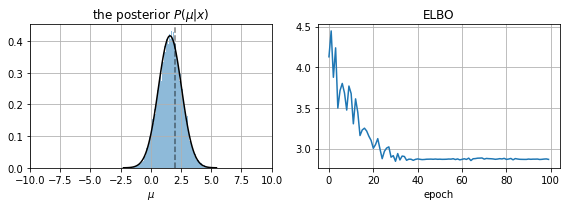

In [7]:
for ax,i in subplots(2, usizex=4):
    if i==0: plot_q()
    if i==1: plot_h_elbo()
plt.tight_layout()

In [8]:
# mu and sigma parameters resulting from the variational optimization
zm.numpy(), tf.math.softplus(zs).numpy()

(1.5835166, 0.9571582)

# Variational with Beta + bijectors family

observe how we build a larger family of unimodal distributions starting off from a Beta distribution and applying bijectors.

- $\mu$: the **latent parameter** we want the posterior for $P(\mu|x)$
- $z_v$ = [$c_0$, $c_1$, $s_c$, $s_h$]: the **variational parameters**


$$
\begin{align}
b & \sim \mathcal{Beta}(c_0, c_1)\\
\mu \sim P(\mu|x) &\approx (b + s_h) \cdot s_c  = q_{z_v}
\end{align}
$$


we first show some distributions generated with random parameters to get a sense of the variability of this family.

observe that the variational parameters include parameters for the original Beta, and the shift and scale bijectors so that we can cover different support ranges for the latent param.

In [12]:
def get_distribution(c0, c1, scale, shift):
    d = tfd.Beta(concentration0=c0, concentration1=c1)
    b = tfb.Chain( [ tfb.Scale(scale), tfb.Shift(shift)])
    t = tfd.TransformedDistribution(d, b)
    return t

In [13]:
def sample_params():
    c0 = np.random.random()*3 + 0.5
    c1 = c0 + np.random.random()*c0/2 - c0/4
    scale = np.random.random()*5
    shift = np.random.random()*10-5
    r = {"c0": c0, "c1": c1, "scale": scale, "shift": shift}
    r = {k:np.float64(v) for k,v in r.items()}
    return r

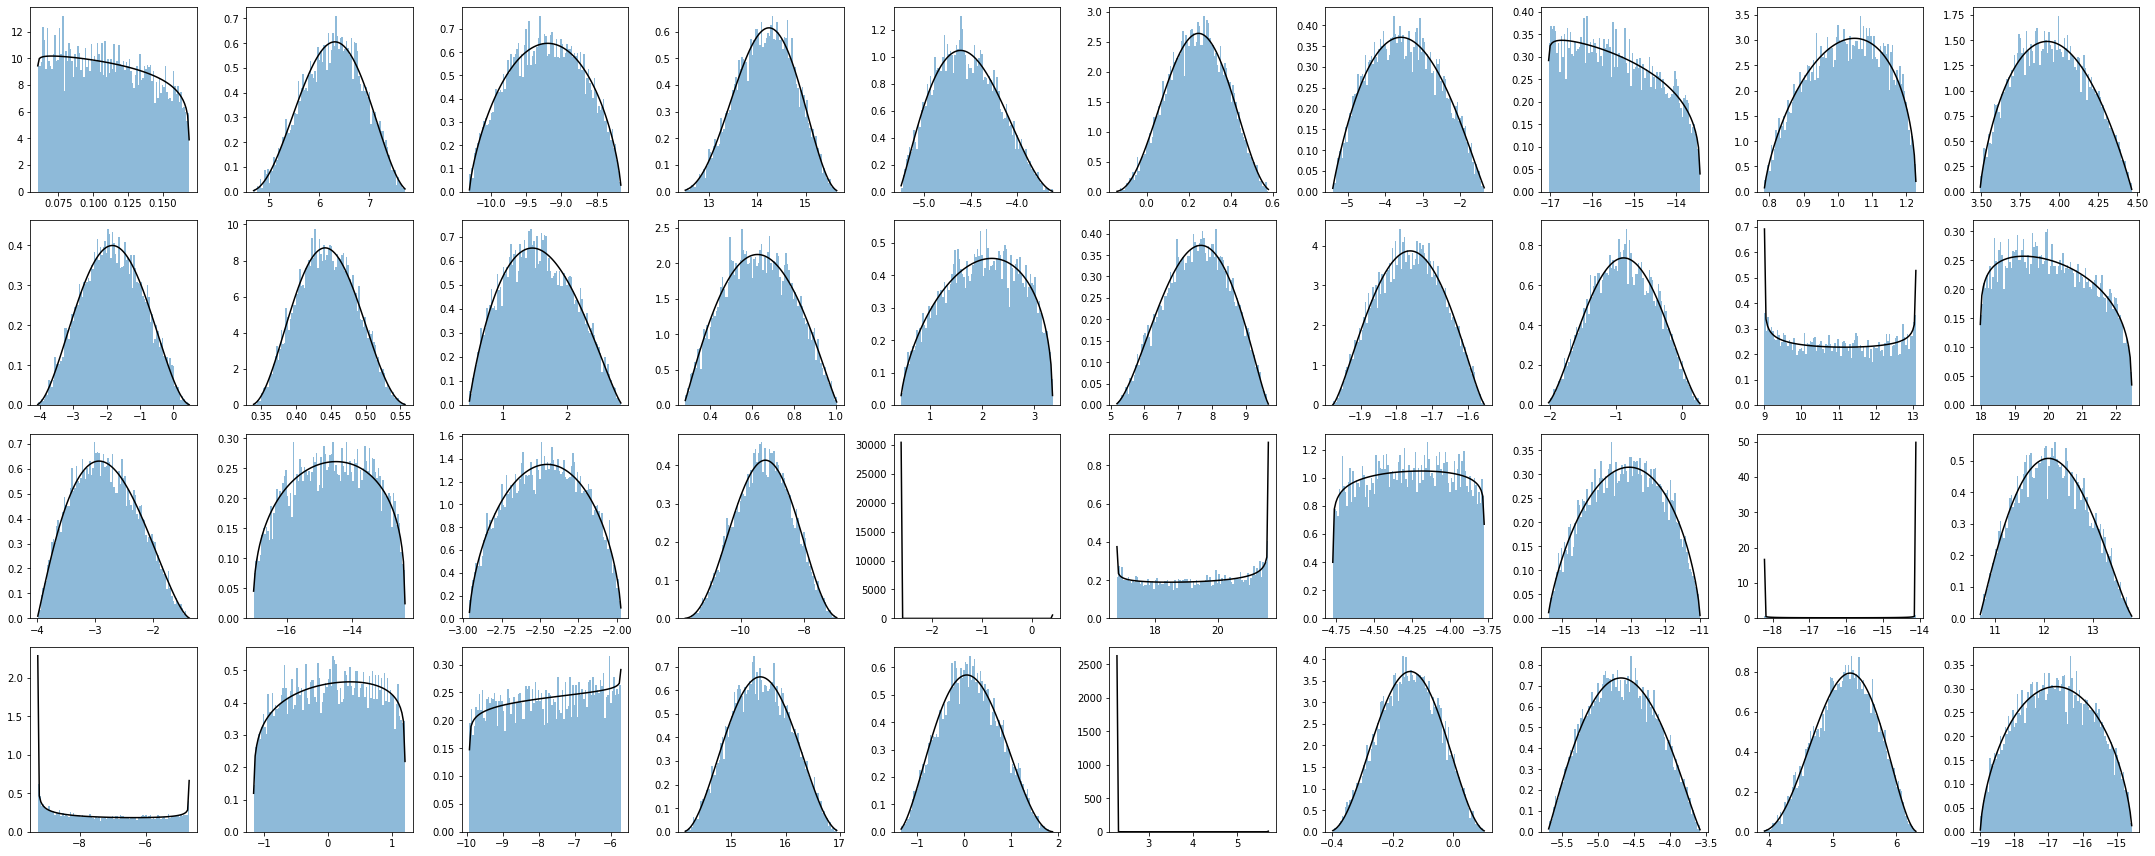

In [11]:
for ax,i in subplots(40, usizex=3, n_cols=10):
    params = sample_params()
    t = get_distribution(**params)

    td = t.sample(10000).numpy()
    plt.hist(td, bins=100, alpha=.5, density=True);
    
    xr = np.linspace(np.min(td), np.max(td), 100)
    plt.plot(xr, np.exp(t.log_prob(xr).numpy()), color="black")
        
plt.tight_layout()

and we do variational inference with this family

In [14]:
zc0 = tf.Variable(1, name="c0", dtype=tf.float32)
zc1 = tf.Variable(1, name="c1", dtype=tf.float32)
zscale = tf.Variable(1, name="scale", dtype=tf.float32)
zshift = tf.Variable(0, name="shift", dtype=tf.float32)
zvars  = [zc0, zc1, zscale, zshift]

optim = tf.keras.optimizers.Adam(learning_rate=.1)

q = lambda: get_distribution(zc0, zc1, zscale, zshift)

In [15]:
h_elbo = fit_variational(epochs=400, mc_sample=4000)

mean 1.67582, std 0.9359352


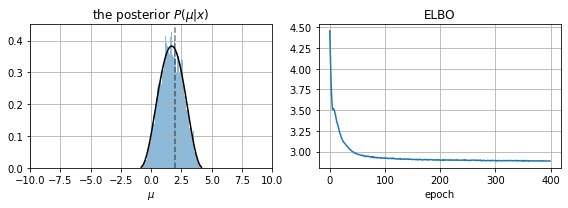

In [16]:
for ax,i in subplots(2, usizex=4):
    if i==0: plot_q()
    if i==1: plot_h_elbo()
plt.tight_layout()

In [17]:
# the variational parameters resulting from the optimization
zvars

[<tf.Variable 'c0:0' shape=() dtype=float32, numpy=3.4702532>,
 <tf.Variable 'c1:0' shape=() dtype=float32, numpy=3.5308838>,
 <tf.Variable 'scale:0' shape=() dtype=float32, numpy=5.31754>,
 <tf.Variable 'shift:0' shape=() dtype=float32, numpy=-0.18867628>]